<a href="https://colab.research.google.com/github/rush254/butterfly-recognition-app/blob/main/notebooks/butterfly_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/Tensorflow/butterflies.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/Image_2349.jpg    
  inflating: train/Image_235.jpg     
  inflating: train/Image_2350.jpg    
  inflating: train/Image_2351.jpg    
  inflating: train/Image_2352.jpg    
  inflating: train/Image_2353.jpg    
  inflating: train/Image_2354.jpg    
  inflating: train/Image_2355.jpg    
  inflating: train/Image_2356.jpg    
  inflating: train/Image_2357.jpg    
  inflating: train/Image_2358.jpg    
  inflating: train/Image_2359.jpg    
  inflating: train/Image_236.jpg     
  inflating: train/Image_2360.jpg    
  inflating: train/Image_2361.jpg    
  inflating: train/Image_2362.jpg    
  inflating: train/Image_2363.jpg    
  inflating: train/Image_2364.jpg    
  inflating: train/Image_2365.jpg    
  inflating: train/Image_2366.jpg    
  inflating: train/Image_2367.jpg    
  inflating: train/Image_2368.jpg    
  inflating: train/Image_2369.jpg    
  inflating: train/Image_237.jpg     
  inflating: train/Image_2370.jpg    

In [3]:
#@title Reading Data
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet50V2

df = pd.read_csv('/content/Training_set.csv')

df['filename'] = df['filename'].apply(lambda x: '/content/train/' + x)

df.head()

filename                     label
0  /content/train/Image_1.jpg          SOUTHERN DOGFACE
1  /content/train/Image_2.jpg                    ADONIS
2  /content/train/Image_3.jpg            BROWN SIPROETA
3  /content/train/Image_4.jpg                   MONARCH
4  /content/train/Image_5.jpg  GREEN CELLED CATTLEHEART

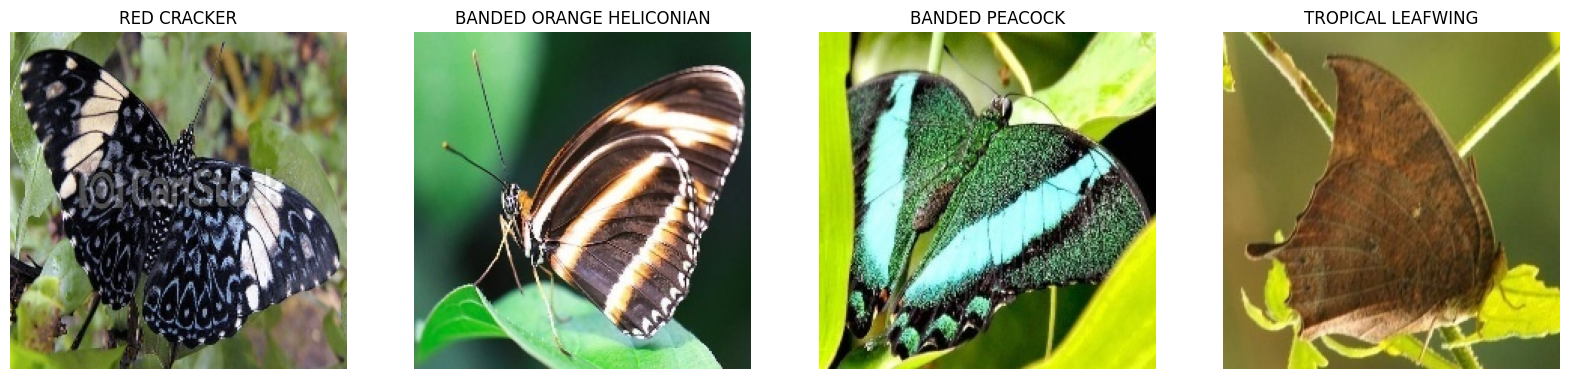

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

# Randomly select 4 rows from the dataframe
random_indices = np.random.choice(df.index, 4, replace=False)
random_rows = df.loc[random_indices]

# Plot the images with captions
plt.figure(figsize=(20, 5))

for i, row in enumerate(random_rows.itertuples()):
    img = Image.open(row.filename)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')

plt.show()

In [4]:
#@title Data Preprocessing and Image Augmentation

train, test = train_test_split(df, test_size=0.2, random_state=42)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    save_format='jpg'
)

test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    save_format='jpg'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


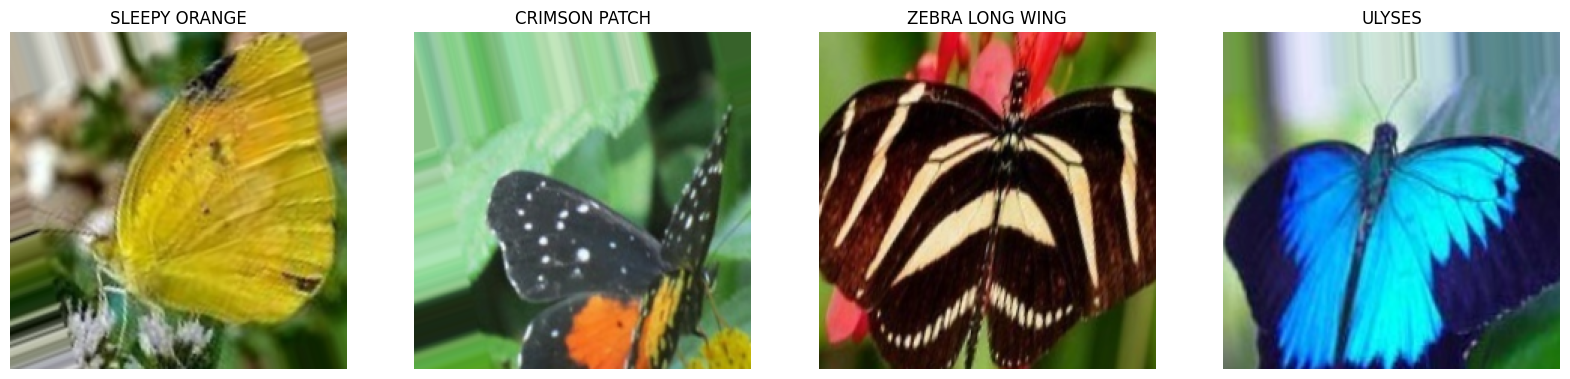

In [31]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

plt.figure(figsize=(20, 5))
for i in range(4):  # Change to display only 4 images in a line
    for k, v in train_generator.class_indices.items():
        if v == np.argmax(labels[i]):
            label = k
    plt.subplot(1, 4, i+1)  # 1 row, 4 columns
    plt.imshow(images[i])
    plt.title(label)
    plt.axis('off')
plt.show()

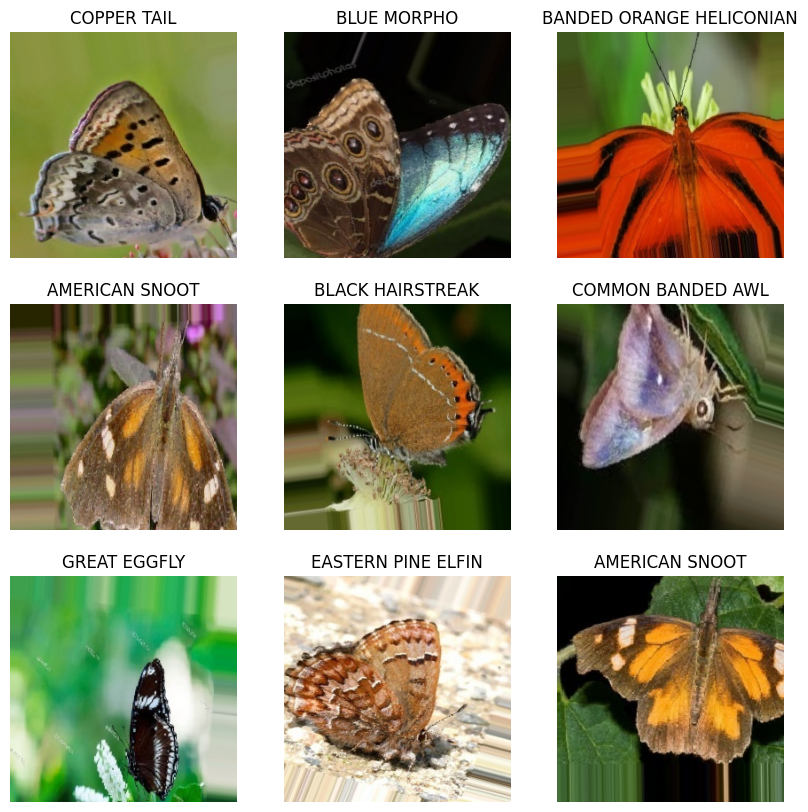

In [ ]:
#@title Viewing Data
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    for k , v  in train_generator.class_indices.items():
        if v == np.argmax(labels[i]):
            label = k
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(label)
    plt.axis('off')
plt.show()

In [8]:
#@title Custom Architecture

inputs = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(75, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='custom_model.h5',  # Path where the model will be saved
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # Mode to save the model when the monitored metric is maximized
    verbose=1                  # Verbosity mode
  )

model.history = model.fit(train_generator,
                          epochs=200,
                          steps_per_epoch=len(train_generator)//32,
                          validation_data=test_generator,
                          validation_steps=len(test_generator)//32,
                          callbacks=[checkpoint_callback])

model = tf.keras.models.load_model('custom_model.h5')

Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: 4.3992 - accuracy: 0.0063
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to custom_model.h5
5/5 [==============================] - 7s 568ms/step - loss: 4.3992 - accuracy: 0.0063 - val_loss: 4.3302 - val_accuracy: 0.0000e+00
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 4.3205 - accuracy: 0.0125
Epoch 2: val_accuracy did not improve from 0.00000
5/5 [==============================] - 2s 423ms/step - loss: 4.3205 - accuracy: 0.0125 - val_loss: 4.3214 - val_accuracy: 0.0000e+00
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 4.3190 - accuracy: 0.0250
Epoch 3: val_accuracy did not improve from 0.00000
5/5 [==============================] - 2s 421ms/step - loss: 4.3190 - accuracy: 0.0250 - val_loss: 4.3169 - val_accuracy: 0.0000e+00
Epoch 4/200
5/5 [==============================] - ETA: 0s - loss: 4.3106 - accuracy: 0.0125
Epoch 4: val_accuracy improved from 0.0000

In [5]:
#@title Tranfer Learning Model

def create_model(model_name, base):

  base_model = base
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)  # Add dropout layer
  predictions = Dense(75, activation='softmax')(x)

  # Create the complete model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = False

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  checkpoint_callback = ModelCheckpoint(
    filepath=f'{model_name}.h5',  # Path where the model will be saved
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # Mode to save the model when the monitored metric is maximized
    verbose=1                  # Verbosity mode
  )

  model.history = model.fit(train_generator,
                            epochs=50,
                            steps_per_epoch=len(train_generator)//32,
                            validation_data=test_generator,
                            validation_steps=len(test_generator)//32,
                            callbacks=[checkpoint_callback])

  model = tf.keras.models.load_model(f'{model_name}.h5')

  return model

In [7]:
#@title MobileNet v3 Model
import keras
base_model = keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, include_preprocessing=False)
model_name = 'mobilenetv3'

model = create_model(model_name, base_model)

4334752/4334752 [==============================] - 1s 0us/step
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 4.5142 - accuracy: 0.0437
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to mobilenetv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 15s 2s/step - loss: 4.5142 - accuracy: 0.0437 - val_loss: 4.5795 - val_accuracy: 0.0938
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 4.2414 - accuracy: 0.1063
Epoch 2: val_accuracy improved from 0.09375 to 0.12500, saving model to mobilenetv3.h5
5/5 [==============================] - 6s 1s/step - loss: 4.2414 - accuracy: 0.1063 - val_loss: 4.3563 - val_accuracy: 0.1250
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 3.7620 - accuracy: 0.1437
Epoch 3: val_accuracy did not improve from 0.12500
5/5 [==============================] - 6s 1s/step - loss: 3.7620 - accuracy: 0.1437 - val_loss: 3.8445 - val_accuracy: 0.1250
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 3.5476 - accuracy: 0.2062
Epoch 4: val_accuracy improved from 0.12500 to 0.21875, saving model to mobilenetv3.h5
5/5 [==============================] - 7s 1s/step - loss: 3.5476 - accuracy: 0.2062 - val_loss: 3.4371 - val_accuracy: 0

In [ ]:
#@title Inception v3 Model

base_model = InceptionV3(weights='imagenet', include_top=False)
model_name = 'inceptionv3'

inception_model = create_model(model_name, base_model)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 5.3084 - accuracy: 0.0500
Epoch 1: val_accuracy improved from -inf to 0.03125, saving model to inceptionv3.h5
5/5 [==============================] - 39s 7s/step - loss: 5.3084 - accuracy: 0.0500 - val_loss: 4.7431 - val_accuracy: 0.0312
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 4.5443 - accuracy: 0.0875
Epoch 2: val_accuracy did not improve from 0.03125
5/5 [==============================] - 29s 6s/step - loss: 4.5443 - accuracy: 0.0875 - val_loss: 4.2711 - val_accuracy: 0.0312
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 4.1324 - accuracy: 0.1125
Epoch 3: val_accuracy improved from 0.03125 to 0.09375, saving model to inceptionv3.h5
5/5 [==============================] - 36s 8s/step - loss: 4.1324 - accuracy: 0.1125 - val_loss: 3.8909 - val_accuracy: 0.0938
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 3.6109 - accuracy: 0.1750
Epoch 4: val_accuracy improve

In [ ]:
#@title Resnet50 v2 Model

base_model = ResNet50V2(weights='imagenet', include_top=False)
model_name = 'resnet50v2'

resnet_model = create_model(model_name, base_model)

94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 4.6738 - accuracy: 0.0629
Epoch 1: val_accuracy improved from -inf to 0.15625, saving model to resnet50v2.h5
5/5 [==============================] - 44s 8s/step - loss: 4.6738 - accuracy: 0.0629 - val_loss: 4.3571 - val_accuracy: 0.1562
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 4.6141 - accuracy: 0.1562
Epoch 2: val_accuracy did not improve from 0.15625
5/5 [==============================] - 40s 8s/step - loss: 4.6141 - accuracy: 0.1562 - val_loss: 4.2169 - val_accuracy: 0.1250
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 3.7224 - accuracy: 0.2375
Epoch 3: val_accuracy improved from 0.15625 to 0.21875, saving model to resnet50v2.h5
5/5 [==============================] - 40s 8s/step - loss: 3.7224 - accuracy: 0.2375 - val_loss: 3.3319 - val_accuracy: 0.2188
Epoch 4/50
5/5 [==============================] - ETA: 0s 

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, data_generator):

    # Get the ground truth labels and the predicted labels
    true_labels = data_generator.classes
    class_indices = list(data_generator.class_indices.keys())

    # Convert predictions to class labels
    predicted_labels = np.argmax(model.predict(data_generator), axis=1)

    # Calculate accuracy, F1 score, precision, and recall
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    # Return the metrics as a dictionary
    metrics = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }

    return metrics

In [10]:
datagen = test_datagen.flow_from_dataframe(
    df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    save_format='jpg'
)

Found 6499 validated image filenames belonging to 75 classes.


In [11]:
#@title Custom Architecture Evaluation

print(evaluate_model(model, datagen))

204/204 [==============================] - 13s 63ms/step
{'accuracy': 0.5674719187567318, 'f1_score': 0.546793468792016, 'precision': 0.6138897531643756, 'recall': 0.5674719187567318}


In [10]:
#@title MobileNet v3 Evaluation

print(evaluate_model(model, datagen))

204/204 [==============================] - 82s 397ms/step
{'accuracy': 0.8302815817818125, 'f1_score': 0.8290953511152005, 'precision': 0.8561104099377371, 'recall': 0.8302815817818125}


In [ ]:
#@title Inception v3 Evaluation

print(evaluate_model(inception_model, datagen))

204/204 [==============================] - 900s 4s/step
{'accuracy': 0.6802585013078936, 'f1_score': 0.6724846765812832, 'precision': 0.7394459929410758, 'recall': 0.6802585013078936}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#@title ResNet50 v2 Evaluation

print(evaluate_model(resnet_model, datagen))

204/204 [==============================] - 1204s 6s/step
{'accuracy': 0.8219726111709493, 'f1_score': 0.818519883478701, 'precision': 0.8474810266897665, 'recall': 0.8219726111709493}


In [24]:
#@title MobileNet Optimization

base_model = keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, include_preprocessing=False)
model_name = 'mobilenetv3_top'

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# unfreeze Top layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
  filepath=f'{model_name}.h5',
  monitor='accuracy',
  save_best_only=True,
  mode='max',
  verbose=1
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)


model.history = model.fit(train_generator,
                          epochs=100,
                          steps_per_epoch=len(train_generator)//32,
                          validation_data=test_generator,
                          validation_steps=len(test_generator)//32,
                          callbacks=[checkpoint_callback, lr_scheduler])


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 5.3023 - accuracy: 0.0250
Epoch 1: accuracy improved from -inf to 0.02500, saving model to mobilenetv3_top.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 15s 1s/step - loss: 5.3023 - accuracy: 0.0250 - val_loss: 4.3650 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 4.0637 - accuracy: 0.1562
Epoch 2: accuracy improved from 0.02500 to 0.15625, saving model to mobilenetv3_top.h5
5/5 [==============================] - 4s 913ms/step - loss: 4.0637 - accuracy: 0.1562 - val_loss: 3.9706 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 3.6451 - accuracy: 0.2375
Epoch 3: accuracy improved from 0.15625 to 0.23750, saving model to mobilenetv3_top.h5
5/5 [==============================] - 2s 516ms/step - loss: 3.6451 - accuracy: 0.2375 - val_loss: 3.6132 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 3.5092 - accuracy: 0.2562
Epoch 4: accuracy improved from 0.23750 to 0.25625, saving model to mobilenetv3_top.h5
5/5 [==============================]

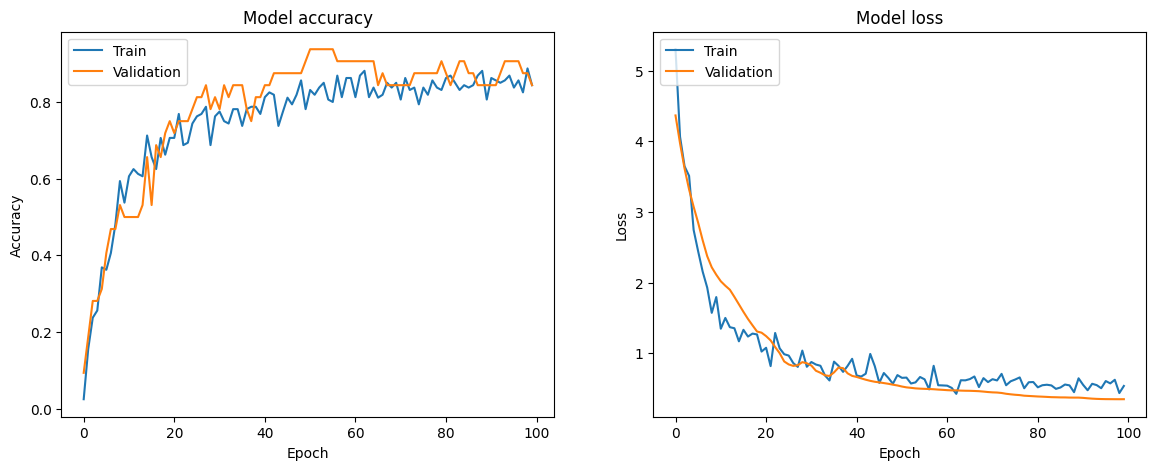

In [25]:
#@title Training and Validation Loss and Accuracy

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [29]:
model = tf.keras.models.load_model(f'{model_name}.h5')

print(evaluate_model(model, datagen))

204/204 [==============================] - 14s 62ms/step
{'accuracy': 0.8859824588398215, 'f1_score': 0.8863426177375806, 'precision': 0.8947540522607215, 'recall': 0.8859824588398215}


204/204 [==============================] - 12s 60ms/step


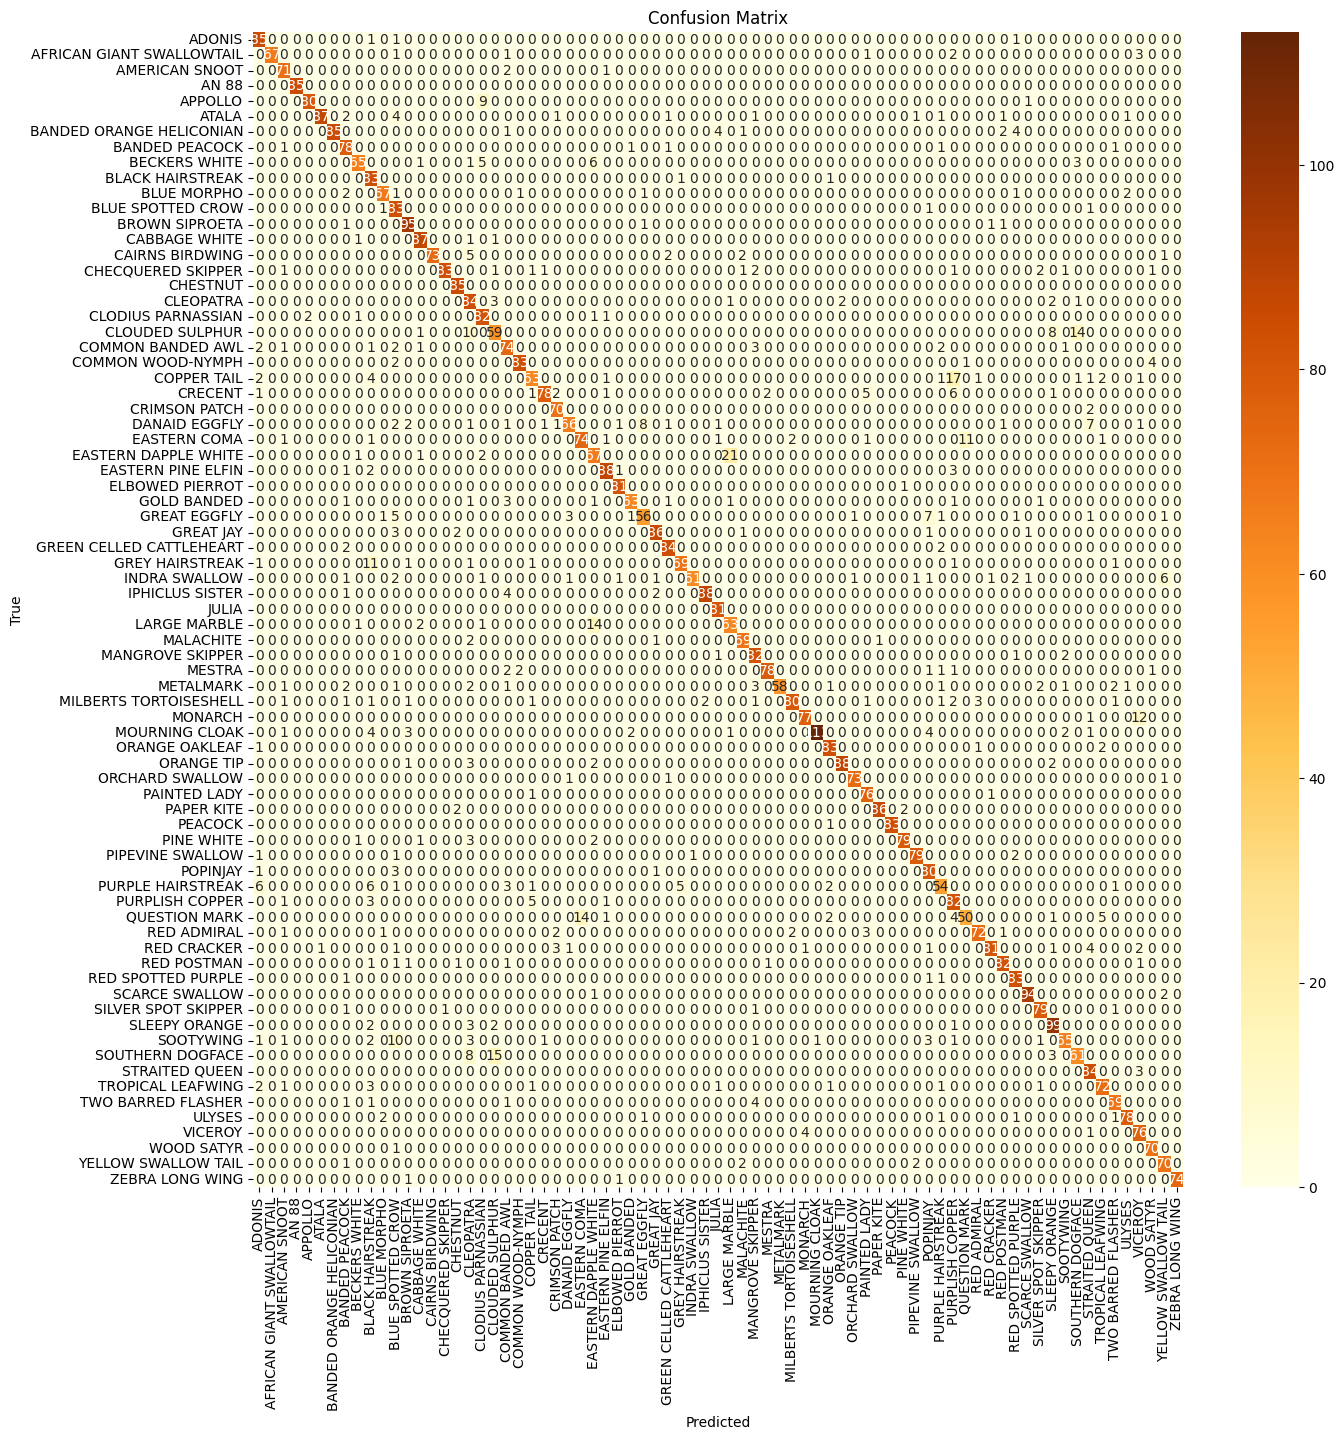

                           precision    recall  f1-score   support

                   ADONIS       0.83      0.97      0.89        88
AFRICAN GIANT SWALLOWTAIL       1.00      0.89      0.94        75
           AMERICAN SNOOT       0.87      0.96      0.91        74
                    AN 88       1.00      1.00      1.00        85
                  APPOLLO       0.98      0.89      0.93        90
                    ATALA       0.99      0.87      0.93       100
 BANDED ORANGE HELICONIAN       1.00      0.88      0.93        97
           BANDED PEACOCK       0.81      0.94      0.87        83
            BECKERS WHITE       0.93      0.80      0.86        81
         BLACK HAIRSTREAK       0.66      0.98      0.79        85
              BLUE MORPHO       0.93      0.89      0.91        75
        BLUE SPOTTED CROW       0.66      0.97      0.78        86
           BROWN SIPROETA       0.90      0.96      0.93        99
            CABBAGE WHITE       0.93      0.97      0.95     

In [30]:
#@title Classification Report and Confusion Matrix

# predictions
Y_pred = model.predict(datagen)
y_pred = np.argmax(Y_pred, axis=1)

# confusion matrix
cm = confusion_matrix(datagen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=datagen.class_indices.keys(), yticklabels=datagen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# classification report
print(classification_report(datagen.classes, y_pred, target_names=datagen.class_indices.keys()))


1/1 [==============================] - 0s 55ms/step


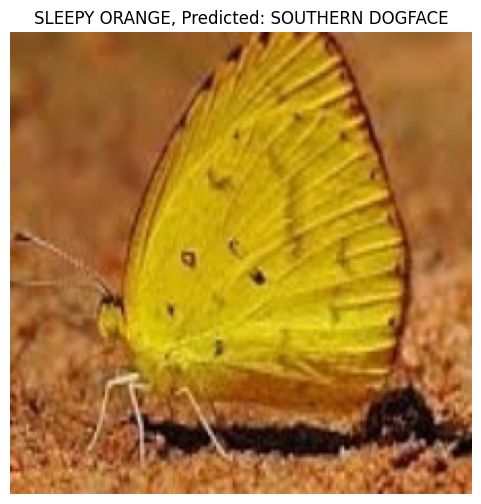

In [26]:
#@title Random Image Classification

import os
import random
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

# Function to load and preprocess a random image from a directory
def load_random_image(directory):
    # Get a list of all image files in the directory
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('jpg', 'jpeg', 'png'))]
    # Select a random image
    img_path = random.choice(image_files)
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the model's input shape
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image
    img_array = preprocess_input(img_array)
    return img_path, img_array

# Directory containing test images
test_images_dir = '/content/train'

# Load and preprocess a random image
img_path, img_array = load_random_image(test_images_dir)

# actual value
actual = df[df['filename'] == img_path]['label'].values[0]

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Display the image along with the predicted label
plt.figure(figsize=(6, 6))
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'{actual}, Predicted: {class_labels[predicted_class]}')
plt.axis('off')
plt.show()


In [28]:
test_generator.class_indices

{'ADONIS': 0,
 'AFRICAN GIANT SWALLOWTAIL': 1,
 'AMERICAN SNOOT': 2,
 'AN 88': 3,
 'APPOLLO': 4,
 'ATALA': 5,
 'BANDED ORANGE HELICONIAN': 6,
 'BANDED PEACOCK': 7,
 'BECKERS WHITE': 8,
 'BLACK HAIRSTREAK': 9,
 'BLUE MORPHO': 10,
 'BLUE SPOTTED CROW': 11,
 'BROWN SIPROETA': 12,
 'CABBAGE WHITE': 13,
 'CAIRNS BIRDWING': 14,
 'CHECQUERED SKIPPER': 15,
 'CHESTNUT': 16,
 'CLEOPATRA': 17,
 'CLODIUS PARNASSIAN': 18,
 'CLOUDED SULPHUR': 19,
 'COMMON BANDED AWL': 20,
 'COMMON WOOD-NYMPH': 21,
 'COPPER TAIL': 22,
 'CRECENT': 23,
 'CRIMSON PATCH': 24,
 'DANAID EGGFLY': 25,
 'EASTERN COMA': 26,
 'EASTERN DAPPLE WHITE': 27,
 'EASTERN PINE ELFIN': 28,
 'ELBOWED PIERROT': 29,
 'GOLD BANDED': 30,
 'GREAT EGGFLY': 31,
 'GREAT JAY': 32,
 'GREEN CELLED CATTLEHEART': 33,
 'GREY HAIRSTREAK': 34,
 'INDRA SWALLOW': 35,
 'IPHICLUS SISTER': 36,
 'JULIA': 37,
 'LARGE MARBLE': 38,
 'MALACHITE': 39,
 'MANGROVE SKIPPER': 40,
 'MESTRA': 41,
 'METALMARK': 42,
 'MILBERTS TORTOISESHELL': 43,
 'MONARCH': 44,
 'MOURNING

In [8]:
model = tf.keras.models.load_model('/content/mobilenetv3_best.h5')

In [6]:
print(np.__version__)

1.25.2
